# Multitaper coherence with gaps

## SOI and Recruitment dataset

The following textbook example was taken from Example 4.21 in the 4th edition of the Shumway & Stoffer time series text where the authors investigated the relationship between the Southern Oscillation Index and recruitment from fish populations. The data are plotted in Fig. 1.5 (p 5), and sampled monthly for a total of 453 samples. We have introduced a 49-sample gap in the data, where the gappy series is shown in black overlaid on the original series in blue.

In [1]:
using Statistics, FFTW, Arpack, LinearAlgebra, Distributions, Multitaper, DelimitedFiles, Plots
using FINUFFT, LaTeXStrings, Plots
gr()

tog = true;
try 
    using RCall
catch
    tog = false;
    println("If you have RCall.jl and an R installation with the astsa package, you can run Shumway and Stoffer's original code. Continuing without it.")
end

┌ Info: Precompiling Multitaper [a81958ac-9ec9-4086-814d-3ae87249a5e8]
└ @ Base loading.jl:1278


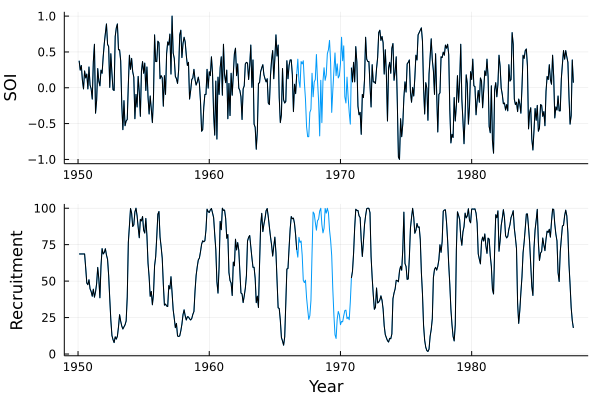

In [2]:
gb, ge = (200,250)
gaptimes = vcat(collect(1:gb),collect(ge:453))
MTdir = dirname(dirname(pathof(Multitaper)))

fn  = "/Examples/data/soirecruitment.dat"
dat = readdlm(MTdir*fn)
N1, p = size(dat)

# Variances of the two series
s1 = var(dat[:,3])
s2 = var(dat[:,4])

p = plot(dat[:,1] .+ dat[:,2]/12, dat[:,3:4], layout=(2,1), legend=false, 
    ylabel = ["SOI" "Recruitment"], xlabel = ["" "Year"])#,xlim=[1960,1965])
p = plot!(dat[collect(1:gb),1].+dat[collect(1:gb),2]/12, dat[collect(1:gb),3:4], layout=(2,1), legend=false, 
    c = :black)
p = plot!(dat[collect(ge:453),1].+dat[collect(ge:453),2]/12, dat[collect(ge:453),3:4], layout=(2,1), legend=false, 
    c = :black)

## Standard Estimation of the spectrum where there are no gaps

Fig. 4.15 (p 212) shows the estimate of the squared coherence computed using standard Daniell tapering and smoothing exactly as in the example from Shumway & Stoffer.

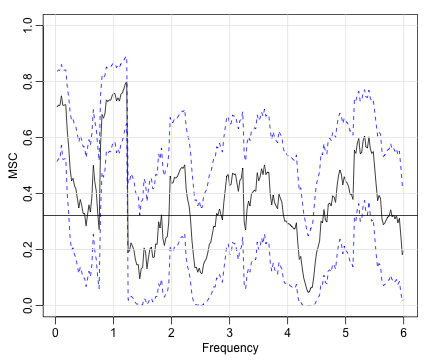

(OrderedCollections.OrderedDict{Symbol,Any}(:coef => [0.05263157894736842, 0.05263157894736842, 0.05263157894736842, 0.05263157894736842, 0.05263157894736842, 0.05263157894736842, 0.05263157894736842, 0.05263157894736842, 0.05263157894736842, 0.05263157894736842],:m => 9), 0.05263157894736842)

In [3]:
if tog 

R"""
library(astsa)
png("/users/charlottehaley/Documents/Repos/gaps/Doc/Figures/Rmsc_soirec.png")
dev.new(width=7, height=4) # default is 7 x 7 inches
par(mar=c(3,3,1,1), mgp=c(1.6,.6,0) )
ker = kernel("daniell",9)
sr = mvspec(cbind(soi,rec), kernel("daniell",9), plot=FALSE)
sr$df # df = 35.8625
f = qf(.999, 2, sr$df-2) # = 8.529792
C = f/(18+f) # = 0.321517
plot(sr, plot.type = "coh", ci.lty = 2, main="", xlab = "Frequency", ylab="MSC")
grid(lty=1, col=gray(.9))
abline(h = C)
dev.off()""";

@rget sr
@rget ker

plot(sr[:freq],Multitaper.unwrapphase(sr[:phase][:]*180/pi))

ker, 1/19

else
    println("This cell would have run the R code, if available.")
end

## Tapering functions for the Multitaper - with and without missing data

The tapering functions used for the multitaper method, the discrete prolate spheroidal sequences, look pretty different from the missing data tapers, the generalized prolate spheroidal sequences. Here we compute them both for visual comparison. The point is that in frequency, both dpss and gpss tapers have most of their mass on the interval (-W,W), and the proportion of their energy on this interval is $\lambda$. 

Beginning with the dpss tapers with no missing values, one gets the following.

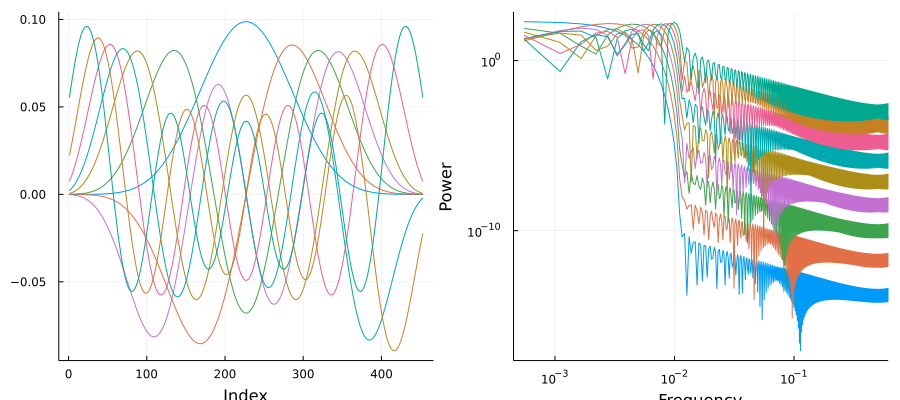

ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error


In [4]:
NW = 5
bw = NW/N1
k = Int64(2*bw*N1-1)
K = k

slep, conc = Multitaper.dpss_tapers(N1,NW,K,:both)
M = 4*N1
freq = LinRange(0,1,M+1)[2:M]

labdpss = Array{LaTeXString,2}(undef,1,K)
for x in 0:(K-1)
    labdpss[x+1] = latexstring("λ_{",(x),"} = ", round(conc[x+1], digits = 9))
end

gr()

p_dpss = [plot(slep, legend=false, xlabel = "Index"), 
          plot(freq, mapslices(x -> abs2.(fft(vcat(x, zeros(M-N1+1))))[2:M], slep, dims=1),
          xscale = :log10, yscale = :log10, label=labdpss, xlims = [freq[1],0.5],
          xlabel = "Frequency", ylabel = "Power")]

plot(p_dpss...,layout=(1,2), size = (900,400))

For the tapers containing missing values, we get the following.

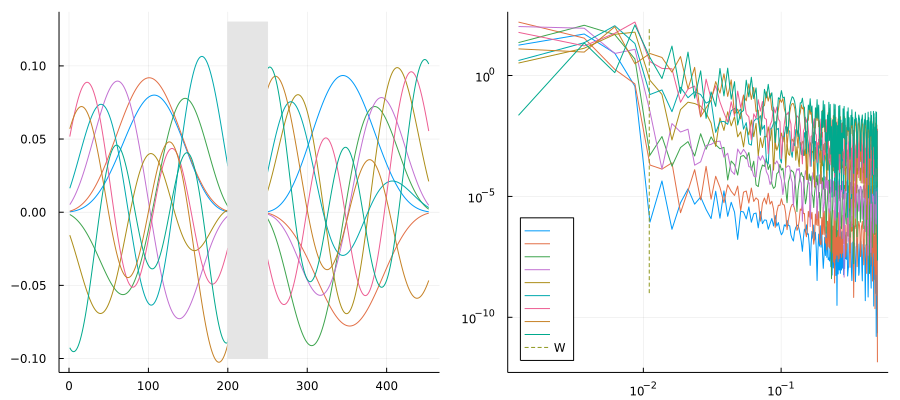

ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error


In [5]:
gaptimes = vcat(collect(1:gb),collect(ge:N1))
N = length(gaptimes)

lam, vv = Multitaper.mdslepian(bw,k,gaptimes)

lab = Array{LaTeXString,2}(undef,1,9)
for x in 0:(k-1)
    lab[x+1] = latexstring("λ_{",(x),"} = ", round(lam[x+1], digits = 7))
end

a = plot(gaptimes, vv[:,1:K], legend = false)
ay,by = (-0.1, 0.13)
ax,bx = (gb,ge)
plot!(a, [ax, bx, bx, ax, ax],[ay, ay, by, by, ay],
        fill = 0, c = RGB(0.9,0.9,0.9), label="missing")

M = 4*N
cent = (gaptimes .- (N1+1)/2)/N1
freq = range(-0.5, stop = 0.5, length = N)  

V = mapreduce(i->abs2.(nufft1d3(Float64.(gaptimes), ComplexF64.(vv[:,i]), -1, 1e-15, 
            pi*collect(LinRange(-1.0, 1, N+1))))[Int64(N/2+1):end], hcat, 1:k)

b = plot(freq[Int64(N/2+1):end],V[2:end,:],yscale = :log10,xscale = :log10,label = lab, legend = :bottomleft)
plot!(b, bw*ones(2,1), [1e-9, 1e2], label = "W", linestyle = :dash)

plot(a,b,layout=(1,2),size = (900,400))

## Multitaper estimates of the SOI and recruitment series, with and without gaps

Here we compute multitaper spectrum/coherences when there is no missing data and when there is missing data.

In [6]:
dt = 1.0/12

multiv = multispec(dat[:,3:4], dt = dt, NW = NW, 
    K = K, jk = true, Ftest = true, guts = true, pad = 2.0)

N = length(gaptimes)
nz = 2*N1/N - 1
M = multiv[1][1].params.M

cross_pkg = mdmultispec(Float64.(gaptimes), dat[gaptimes,4:-1:3], nz=nz, dt=dt);

In the next figure, solid lines show the multitaper version of the spectrum, MSC estimate, and phase, where time-bandwidth product was set to 5 and 6 tapers were used. The gappy spectrum estimates, coherences, and phases, are shown with dotted lines. In comparison with the standard periodogram estimate, the multitaper requires much less smoothing to be consistent. The spectra and coherences for the data without gaps (solid lines) and with gaps (dashed lines) shows good agreement. 

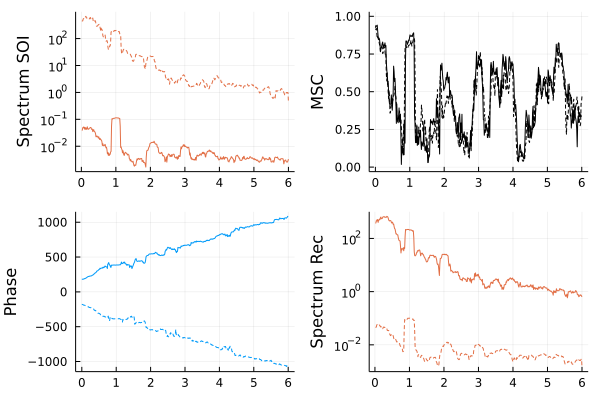

In [7]:
plot(multiv, ylabel=["Spectrum SOI" "MSC" "Phase" "Spectrum Rec"], legend=false)
plot!(cross_pkg, linestyle=:dash)

## Comparison of Daniell and Multitaper estimates

Putting it altogether, we can compare the estimates all in one 4-panel plot, omitting confidence intervals for now. We'll highlight the El Nino band with yellow.

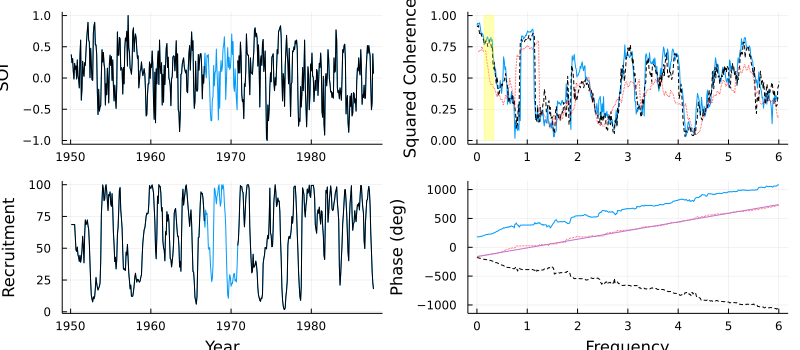

In [8]:
q = plot(multiv[2], phase = true, legend = false, 
    label = "Multitaper estimate")
q = plot!(cross_pkg[2][1,2].f, [Multitaper.tanhtrans.(cross_pkg[2][1,2].coh, 9) cross_pkg[2][1,2].phase],
    c = :black, layout = (2, 1), linestyle = :dash, 
    label = "MT with gaps")
if tog
q = plot!(sr[:freq], [sr[:coh] Multitaper.unwrapphase(sr[:phase][:]*180/pi,:deg)], layout = (2,1), 
    c = :red, linestyle=:dot, 
    label = "R coherence estimate")
end
plot!(q, vcat((1/7)*ones(2,1),(1/3)*ones(2,1)),[0,1,1,0],
    fill = (0,0.3,:yellow), line=(:yellow, 0.3), 
    label = "El Nino band")
plot!(q, [0, 6], [200, 1100] .- 360.0, subplot = 2, layout = (2, 1), 
    label = "Estimated linear phase")

plot(p, q, size = (800, 350))

The slope of the phase is approximately 150 degrees per cycle per year, which amounts to a delay of recruitment with respect to SOI, in months, of:

In [9]:
println("$((900/6)*(pi/180)*(12/(2*pi))) months")

5.0 months


Alternatively, one can interpret this as a delay of SOI with respect to recruitment of 7 months. However, it is more likely that recruitment is dependent on SOI than the other way around. 

### A closer look at the phase

Note that the phases in the bottom left of the 4-panel plot above resemble each other but are sometimes offset by 360 degrees. This would mean they are equivalent, but to compare these better, one can look at the angle of the phase factor, i.e. 

$$ \frac{e^{i\phi_1}}{e^{i\phi_2}}. $$

The angle of the phase factor is shown in the next figure.

In search of a better phase comparison, we compute the phase factors for each of the estimates where the comparison is done against the estimated line of best fit (circular subtraction of the line y = 150x + 180). This reproduces the figure from the second example in the paper. 

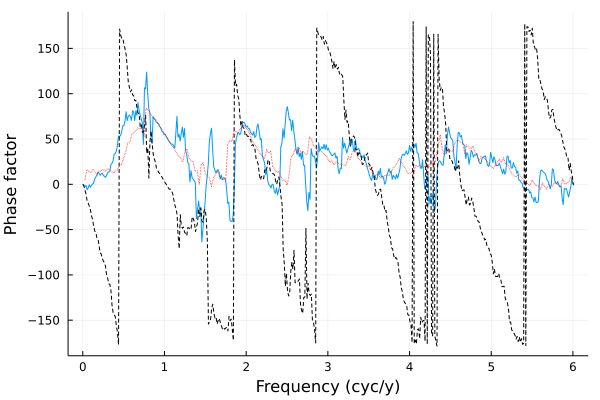

In [10]:
lobfun(f) = -180 .+ 150.0*f
phase_fact(f, p) = (180.0/pi)*angle.(exp.(1.0im*p*(pi/180.0))./exp.(1.0im*lobfun.(f)*(pi/180.0)))

r = plot(multiv[2][1,2].f, phase_fact(multiv[2][1,2].f, multiv[2][1,2].phase),
    label = "MT phase estimate", xlabel = "Frequency (cyc/y)", ylabel = "Phase factor",
    legend = false)
r = plot!(cross_pkg[2][1,2].f, phase_fact(cross_pkg[2][1,2].f, cross_pkg[2][1,2].phase),
    line = (:black, :dash),
    label = "MT phase w gaps")
if tog
r = plot!(sr[:freq], phase_fact(sr[:freq], Multitaper.unwrapphase(sr[:phase][:]*180/pi,:deg)),
    line = (:red, :dot),
    label = "SS phase")
end

Replacing the above phase plot gives the figure from the paper.

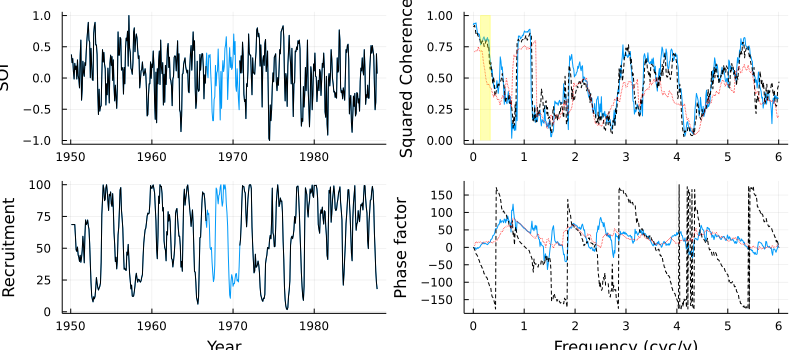

In [11]:
qr = plot(multiv[2], phase = false, legend = false, 
    label = "Multitaper estimate")

qr = plot!(cross_pkg[2][1,2].f, Multitaper.tanhtrans.(cross_pkg[2][1,2].coh, 9),
    c = :black, linestyle = :dash, 
    label = "MT with gaps")
if tog
qr = plot!(sr[:freq], sr[:coh],
    c = :red, linestyle=:dot, 
    label = "R coherence estimate")
end
plot!(qr, vcat((1/7)*ones(2,1),(1/3)*ones(2,1)),[0,1,1,0],
    fill = (0,0.3,:yellow), line=(:yellow, 0.3), 
    label = "El Nino band")

plot(p, plot(qr,r,layout=(2,1)), layout = (1, 2), size = (800, 350))

## Confidence intervals for the MSC

Let's plot the multitaper coherence estimates with and without gaps together with confidence intervals on the transformed scale. The result we get shows generally comparable widths for the 95% confidence interval.

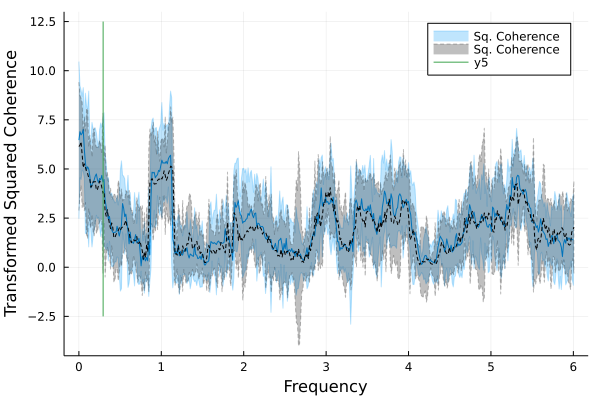

In [12]:
pp = plot(multiv[2][1, 2], xlim = [0, 6],
    ylabel = "Transformed MSC", 
    label = "MT estimate")
plot!(pp, cross_pkg[2][1, 2], linestyle = :dash, c = :black,
    label = "MT with gaps")
plot!((1/3.4)*ones(2, 1), [-2.5, 12.5])

One can also compute significance for the MSC, which is done in the following recipe.

In [13]:
# This bonus plots recipe for coherences is not built in because of a feature of Plots.jl 
# that would require Plots.jl to become a dependency, so we load it in separately:
using RecipesBase
include(MTdir*"/src/PlotsRecipes/Coherence_plot.jl")

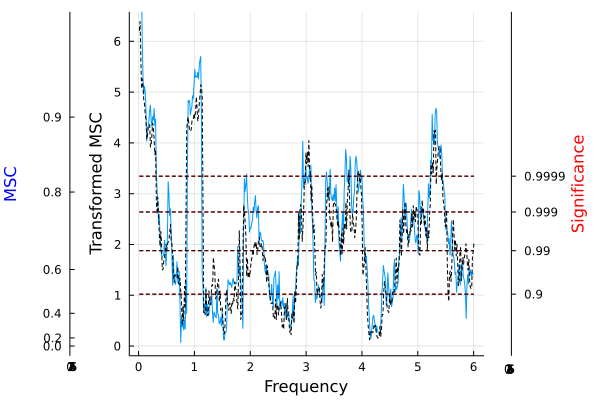

In [14]:
plot(multiv[2][1,2], siglines = true, msclines = false, sigMax = 4, legtext = false, 
       force_ylims = nothing, mscaxis = true, sigaxis = true, jk = false)
plot!(cross_pkg[2][1,2], c = :black, linestyle=:dash, msclines = false, jk = false)

### A closer look at the difference between the two phases

The result of the phase comparison is that there are some large-ish differences in numerous places, but this difference tends to center around 0. Here we difference the phases of the coherency estimates with and without gaps and the textbook example of the phase and show confidence intervals. Indeed, there are several places in which the difference in phase is very large.

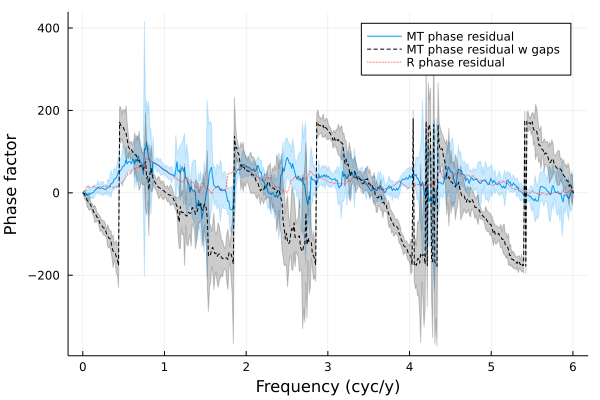

In [15]:
mtphasefact = phase_fact(multiv[2][1,2].f, multiv[2][1,2].phase)
mtgapphasefact = phase_fact(cross_pkg[2][1,2].f, cross_pkg[2][1,2].phase)

using StatsFuns
z = norminvcdf(0,1,0.975)

qq = plot(multiv[2][1,2].f, mtphasefact, c = 1,
    label = "MT phase residual", xlabel = "Frequency (cyc/y)", ylabel = "Phase factor")
plot!(qq, vcat(multiv[2][1,2].f, multiv[2][1,2].f[end:-1:1]), 
    vcat(mtphasefact,mtphasefact[end:-1:1]) .+ z*vcat((multiv[2][1,2].jkvar[2]), -(multiv[2][1,2].jkvar[2][end:-1:1]))
    , c = 1, fill = (0, 0.2), linealpha = 0.2, primary = false,
    label = "MT phase CI")

plot!(qq, cross_pkg[2][1,2].f, mtgapphasefact,
    line = (:black, :dash),
    label = "MT phase residual w gaps")

plot!(qq, vcat(cross_pkg[2][1,2].f, cross_pkg[2][1,2].f[end:-1:1]), 
    vcat(mtgapphasefact,mtgapphasefact[end:-1:1]) .+ z*vcat((cross_pkg[2][1,2].jkvar[2]), -(cross_pkg[2][1,2].jkvar[2][end:-1:1]))
    , c = :black, fill = (0, 0.2), linealpha = 0.2, primary = false,
    label = "MT gaps phase CI")

if tog
plot!(qq, sr[:freq], phase_fact(sr[:freq], Multitaper.unwrapphase(sr[:phase][:]*180/pi,:deg)),
    line = (:red, :dot),
    label = "R phase residual")
end

## Different gaps

This is all very well, but what if I just cherry-picked this number of gaps for its nice properties? Here's an additional example showing good performance for aribitrary numbers of gaps and gap indices.

In [16]:
using Random
Random.seed!(456)

Ngaps = 3
st = sort(randperm(N1)[1:Ngaps])
len = map(i -> rand(1:i), (diff(vcat(st, N1)) .- 1));

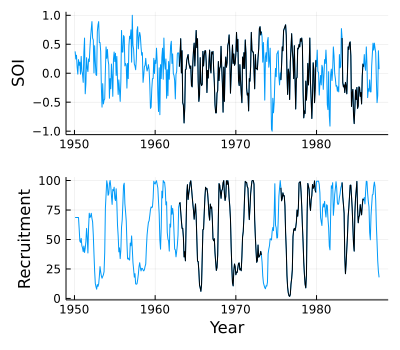

In [17]:
p = plot(dat[:,1] .+ dat[:,2]/12, dat[:,3:4], layout=(2,1), legend=false, 
    ylabel = ["SOI" "Recruitment"], xlabel = ["" "Year"], size = (400, 350))#,xlim=[1960,1965])

qt = collect(1:st[1])
for i = 1:Ngaps
t = st[i]:(st[i]+len[i])
p = plot!(dat[collect(t),1].+ dat[collect(t),2]/12, dat[collect(t),3:4], layout=(2,1), legend=false, 
    c = :black)
    if i < Ngaps
    qt = vcat(qt, collect(st[i]+len[i]:st[i+1]))
    elseif i == Ngaps
        qt = vcat(qt, collect(st[Ngaps]+len[i]:N1))
    end
end
p

In [18]:
println("$(100*length(qt)/N1) percent of the data is not missing and there are $Ngaps gaps.")

55.18763796909492 percent of the data is not missing and there are 3 gaps.


In [19]:
cross_pkgNgaps = mdmultispec(qt, dat[qt,3:4], nz=nz, dt=dt)
cross_pkgNgaps[1][1].S ./= 2.0
cross_pkgNgaps[1][2].S ./= 2.0;

plot(multiv, ylabel=["Spectrum SOI" "MSC" "Phase" "Spectrum Rec"], legend=false)
plot!(cross_pkgNgaps, linestyle=:dash)
plot!(xlabel = ["" "" "Frequency (cyc/y)" "Frequency (cyc/y)"])

LoadError: [91mMethodError: no method matching nufft1d3(::Array{Int64,1}, ::Array{Complex{Float64},1}, ::Int64, ::Float64, ::Array{Float64,1})[39m
[91m[0mClosest candidates are:[39m
[91m[0m  nufft1d3([91m::Array{Float64,N} where N[39m, ::Array{Complex{Float64},N} where N, ::Integer, ::Float64, ::Array{Float64,N} where N) at /Users/charlottehaley/.julia/packages/FINUFFT/EEFSZ/src/FINUFFT.jl:402[39m
[91m[0m  nufft1d3([91m::Array{Float64,N} where N[39m, ::Array{Complex{Float64},N} where N, ::Integer, ::Float64, ::Array{Float64,N} where N, [91m::nufft_opts[39m) at /Users/charlottehaley/.julia/packages/FINUFFT/EEFSZ/src/FINUFFT.jl:402[39m